In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


def data_set_from_csv(train_file: str, test_file: str = None):
    def read_file(file):
        ds = pd.read_csv(file)
        return ds.values[:, :-1], ds.values[:, -1]

    train_X, train_y = read_file(train_file)
    test_X, test_y = None, None

    if test_file is not None:
        test_X, test_y = read_file(test_file)
    return DataSet(train_X, train_y, test_X, test_y)


class DataSet:
    def __init__(self, X: np.ndarray, y: np.ndarray, test_X=None, test_y=None):
        self.X = X
        self.y = y

        self._test_X = test_X
        self._test_y = test_y

    def get_X(self):
        return self.X

    def get_y(self):
        return self.y

    def get_test_X(self):
        return self._test_X

    def get_test_y(self):
        return self._test_y

    def count(self):
        return self.y.shape[0]

    def get_for_cross_validation(self, train_indices, test_indices):
        train_X, test_X = self.X[train_indices], self.X[test_indices]
        train_y, test_y = self.y[train_indices], self.y[test_indices]

        return DataSet(X=train_X, y=train_y, test_X=test_X, test_y=test_y)

    def test_train_split(self, **kwargs):
        X, tX, y, ty = train_test_split(self.X, self.y, **kwargs)
        return DataSet(X, y), DataSet(tX, ty)

    def __repr__(self):
        count, features = self.X.shape
        test_count = self.get_test_X().shape[0] if self.get_test_X() is not None else 0
        return f"DataSet[features={features},count={count},test_count={test_count}]"


class DSWithSplit:

    def __init__(self, X, y, split):
        assert X is not None
        assert y is not None
        assert split is not None

        self.X = X
        self.y = y
        self.splits = split

    def __repr__(self):
        return f'DataSet[n_features={self.X.shape[1]},size={self.X.shape[0]},split_size={len(self.splits)}]'

    def split_first(self):
        assert len(self.splits) > 0

        splt = self.splits[0]
        return self.X[splt[0]], self.y[splt[0]], self.X[splt[1]], self.y[splt[1]]


class DSBuilder:
    _TEST = 'test'
    _TRAIN = 'train'

    def __init__(self):
        self._parts = []

    @staticmethod
    def of(ds: DataSet):
        b = DSBuilder()
        b.append(ds=ds)
        return b.build()

    def append(self, train_X: np.ndarray = None, train_y: np.ndarray = None,
               test_X: np.ndarray = None, test_y: np.ndarray = None,
               ds: DataSet = None):

        if ds is not None:
            return self.append(ds.get_X(), ds.get_y(), ds.get_test_X(), ds.get_test_y())

        check = {
            "train_X": train_X is None,
            "train_y": train_y is None,
            "test_X": test_X is None,
            "test_y": test_y is None
        }
        is_none = list(map(lambda kv: kv[0], filter(lambda kv: kv[1], check.items())))

        if len(is_none) != 0:
            raise RuntimeError("Couldn't append, because " + ", ".join(is_none) + " is none")

        if test_X.shape[0] != test_y.shape[0]:
            raise RuntimeError("Couldn't append, because test data have diff shape")

        if train_X.shape[0] != train_y.shape[0]:
            raise RuntimeError("Couldn't append, because train data have diff shape")

        self._parts.append(
            (train_X, train_y)
        )
        self._parts.append(
            (test_X, test_y)
        )
        return self

    def build(self) -> DSWithSplit:
        first_train, first_test = self._parts[0], self._parts[1]

        def concat(trn, tst):
            return np.concatenate((trn[0], tst[0])), np.concatenate((trn[1], tst[1]))

        res_X, res_y = concat(first_train, first_test)

        cv_res = [(0, len(first_train[0]), len(res_X))]

        for i in range(2, len(self._parts), 2):
            train = self._parts[i]
            test = self._parts[i + 1]
            start_idx = cv_res[-1][-1]

            add_X, add_y = concat(train, test)

            res_X = np.concatenate((res_X, add_X))
            res_y = np.concatenate((res_y, add_y))

            cv_res.append((start_idx, len(train[0]), len(res_X)))

        cv = []
        for start, len_train, end in cv_res:
            cv.append((range(start, start + len_train), range(start + len_train, end)))

        return DSWithSplit(res_X, res_y, list(map(lambda c: (list(c[0]), list(c[1])), cv)))


In [2]:
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
from random import shuffle
import statistics

COLORS = [
    "#BA68C8",
    "#e57373",
    "#F06292",
    "#64B5F6",
    "#4DB6AC",
    "#FFB74D",
    "#90A4AE"
]

DARK = [
    "#311B92",
    "#263238",
    "#004D40"
]


def colors(cs):
    i = 0
    lst = [c for c in cs]
    shuffle(lst)
    while True:
        i += 1
        yield lst[i % len(lst)]


def hist(data: dict, index, title='', x_label='', y_label=''):
    """
    Построение гистограммы

    :param data: словарь { key -> [value] } - где длина занчений равна длине индексов
    :param index: индексы по оси X (значения)
    :param title: название графика
    :param x_label: подпись по X
    :param y_label: подпись по Y
    """
    df = pd.DataFrame(data, index=index)
    df.plot(kind='bar')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


def metric_plot(data: dict, x_values: List, title='', x_label='', metric='Accuracy', y_extend=0.2, with_text=True,
                default_color=False, fit_x=False, n_col=2):
    y_max = 0
    y_min = 2
    for v in data.values():
        y_max = max(y_max, max(v))
        y_min = min(y_min, min(v))

    dy = y_max - y_min

    y_max += dy * y_extend
    y_min = max(0, y_min - dy * y_extend)

    for_data = colors(COLORS)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(metric)
    plt.ylim(y_min, y_max)

    text_shift = dy * 0.025

    maximums = []
    for k, v in data.items():
        max_value = max(v)
        target_x = x_values[v.index(max_value)]

        maximums.append((target_x, max_value, k))
        xv = list(range(len(x_values))) if fit_x else x_values
        if fit_x:
            plt.xticks(xv, labels=x_values)
        if default_color:
            plt.plot(xv, v)
        else:
            plt.plot(xv, v, color=next(for_data))

    if not fit_x:
        xx = []
        yy = []
        x_med = statistics.median(x_values)
        for x, y, k in maximums:
            xx.append(x)
            yy.append(y)
            txt = f"{k}, depth: {x}\n{metric}: {y}"
            ha = 'left' if x < x_med else 'right'
            if with_text:
                plt.text(x, y + text_shift, txt,
                         horizontalalignment=ha,
                         verticalalignment='bottom')

        plt.scatter(xx, yy, marker='x', color='#606060')

    plt.legend(list(data.keys()), loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=n_col)
    plt.show()


In [19]:
import random
from sklearn.metrics import accuracy_score
import imageio
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from functools import reduce
from matplotlib import pyplot as plt
from tqdm import tqdm
import os


STEPS = 99
GRID_POINTS = 100
GIF_FPS = 3


def read_dataset(filename) -> DataSet:
    data = pd.read_csv(filename)
    X = data.values[:, :-1]
    tmp_y = data.values[:, -1]
    y = np.vectorize(lambda t: 1 if t == 'P' else -1)(tmp_y)
    return DataSet(X, y)


def generate_gif(name):
    gn = f'img/{name}/{random.randint(0, 100000000)}.gif'
    imageio.mimsave(
        gn,
        [imageio.imread(f"img/{name}/{i}.png") for i in range(1, STEPS)],
        fps=GIF_FPS
    )
    print(f'![SegmentLocal]({gn} "{name}")')

def initial_weights(n):
    return np.ones(n) / n


class AdaBoost:
    def __init__(self, n_estimator=100, callback=None, verbose=False):
        self.clfs = []
        self.n_estimator = n_estimator
        self.a = np.array([])
        self.callback = callback
        self.verbose = verbose

    def fit_one(self, X, y, weights, step):
        classifier = DecisionTreeClassifier(max_depth=2)
        indices = random.choices(range(len(X)), weights=weights, k=len(X))
        classifier.fit(X[indices], y[indices])

        predicted = classifier.predict(X)
        error = weights[predicted != y].sum()

        alpha = 0.5 * np.log((1 - error) / error) if np.isclose(0, error) else 1

        weights *= np.exp(np.multiply(y, predicted) * (-alpha))

        self.clfs.append(classifier)
        self.a = np.append(self.a, alpha)
        if self.callback is not None:
            self.callback(clf=self, step=step + 1)
        return weights / weights.sum()

    def fit(self, X, y):
        reduce(
            lambda ws, step: self.fit_one(X, y, ws, step),
            tqdm(range(self.n_estimator)) if self.verbose else range(self.n_estimator),
            initial_weights(len(X))
        )

    def predict(self, X):
        pred = np.array(list(map(lambda clf: clf.predict(X), self.clfs)))
        return np.sign(self.a @ pred)


def scatter(X, **kwargs):
    assert X.shape[1] == 2

    xx = X[:, 0]
    yy = X[:, 1]
    plt.scatter(xx, yy, **kwargs)


def draw(ds: DataSet, bgX, bgY, step, name):
    X = ds.X
    y = ds.y
    fig = plt.figure()

    scatter(X[y >= 0], marker='+', color='green')
    scatter(X[y < 0], marker='_', color='red')
    scatter(bgX[bgY >= 0], marker='.', color='green', alpha=0.15)
    scatter(bgX[bgY < 0], marker='.', color='red', alpha=0.15)

    plt.title(f'step {step}/{STEPS}')
    fig.savefig(f"img/{name}/{step}")
    plt.close(fig)


def callback(ds: DataSet, bgX, name):
    def inner(clf=None, step=None):
        bgY = clf.predict(bgX)
        draw(ds, bgX, bgY, step, name)

    return inner


def train(ds: DataSet, name):
    min_x, min_y = ds.X.min(axis=0)
    max_x, max_y = ds.X.max(axis=0)

    background_X = np.array(
        list(
            zip(
                np.repeat(np.linspace(min_x, max_x, GRID_POINTS), GRID_POINTS),
                np.tile(np.linspace(min_y, max_y, GRID_POINTS), GRID_POINTS)
            )
        )
    )

    clf = AdaBoost(n_estimator=STEPS, callback=callback(ds, background_X, name), verbose=True)
    clf.fit(ds.X, ds.y)


def test(ds: DataSet, name):
    train_ds, test_ds = ds.test_train_split(test_size=0.33)

    metric_data = {
        "test": [],
        "train": []
    }

    def add_metric(ds, clf, ds_name):
        metric_data[ds_name].append(accuracy_score(ds.y, clf.predict(ds.X)))

    def clbck(clf, step):
        add_metric(test_ds, clf, "test")
        add_metric(train_ds, clf, "train")

    clf = AdaBoost(n_estimator=STEPS, callback=clbck, verbose=True)
    clf.fit(train_ds.X, train_ds.y)

    metric_plot(metric_data, x_label='Steps', x_values=list(range(1, STEPS + 1)), title=f'Accuracy for {name}',
                default_color=True)


def safe(f):
    try:
        f()
    except:
        pass


def process(name):
    safe(lambda: os.mkdir("img"))
    safe(lambda: os.makedirs(f"img/{name}"))

    ds = read_dataset(f'data/{name}.csv')

    train(ds, name)
    test(ds, name)
    generate_gif(name)


  2%|▏         | 2/99 [00:00<00:07, 13.63it/s]

Train


 38%|███▊      | 38/99 [00:00<00:00, 378.07it/s]

Metric


100%|██████████| 99/99 [00:00<00:00, 181.75it/s]


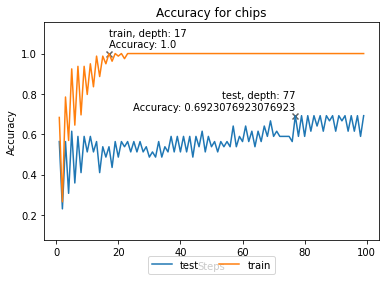

![SegmentLocal](img/chips/76984091.gif "chips")


In [15]:
process('chips')

  2%|▏         | 2/99 [00:00<00:06, 14.91it/s]

Train


 37%|███▋      | 37/99 [00:00<00:00, 357.97it/s]

Metric


100%|██████████| 99/99 [00:00<00:00, 140.22it/s]


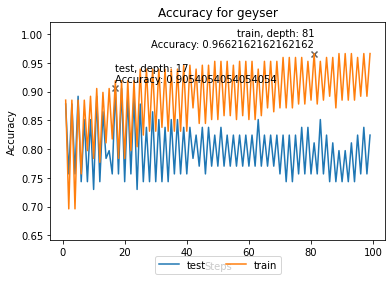

![SegmentLocal](img/geyser/42627116.gif "geyser")


In [18]:
process("geyser")


![SegmentLocal](img/chips/76984091.gif "chips")